## Motion Tracking Report

#### Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import butter, filtfilt, freqz
from scipy.fft import fft
from scipy.stats import entropy

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA



### a) Pre-processing, segmentation, feature extraction:

#### Pre-Processing: Filter Design

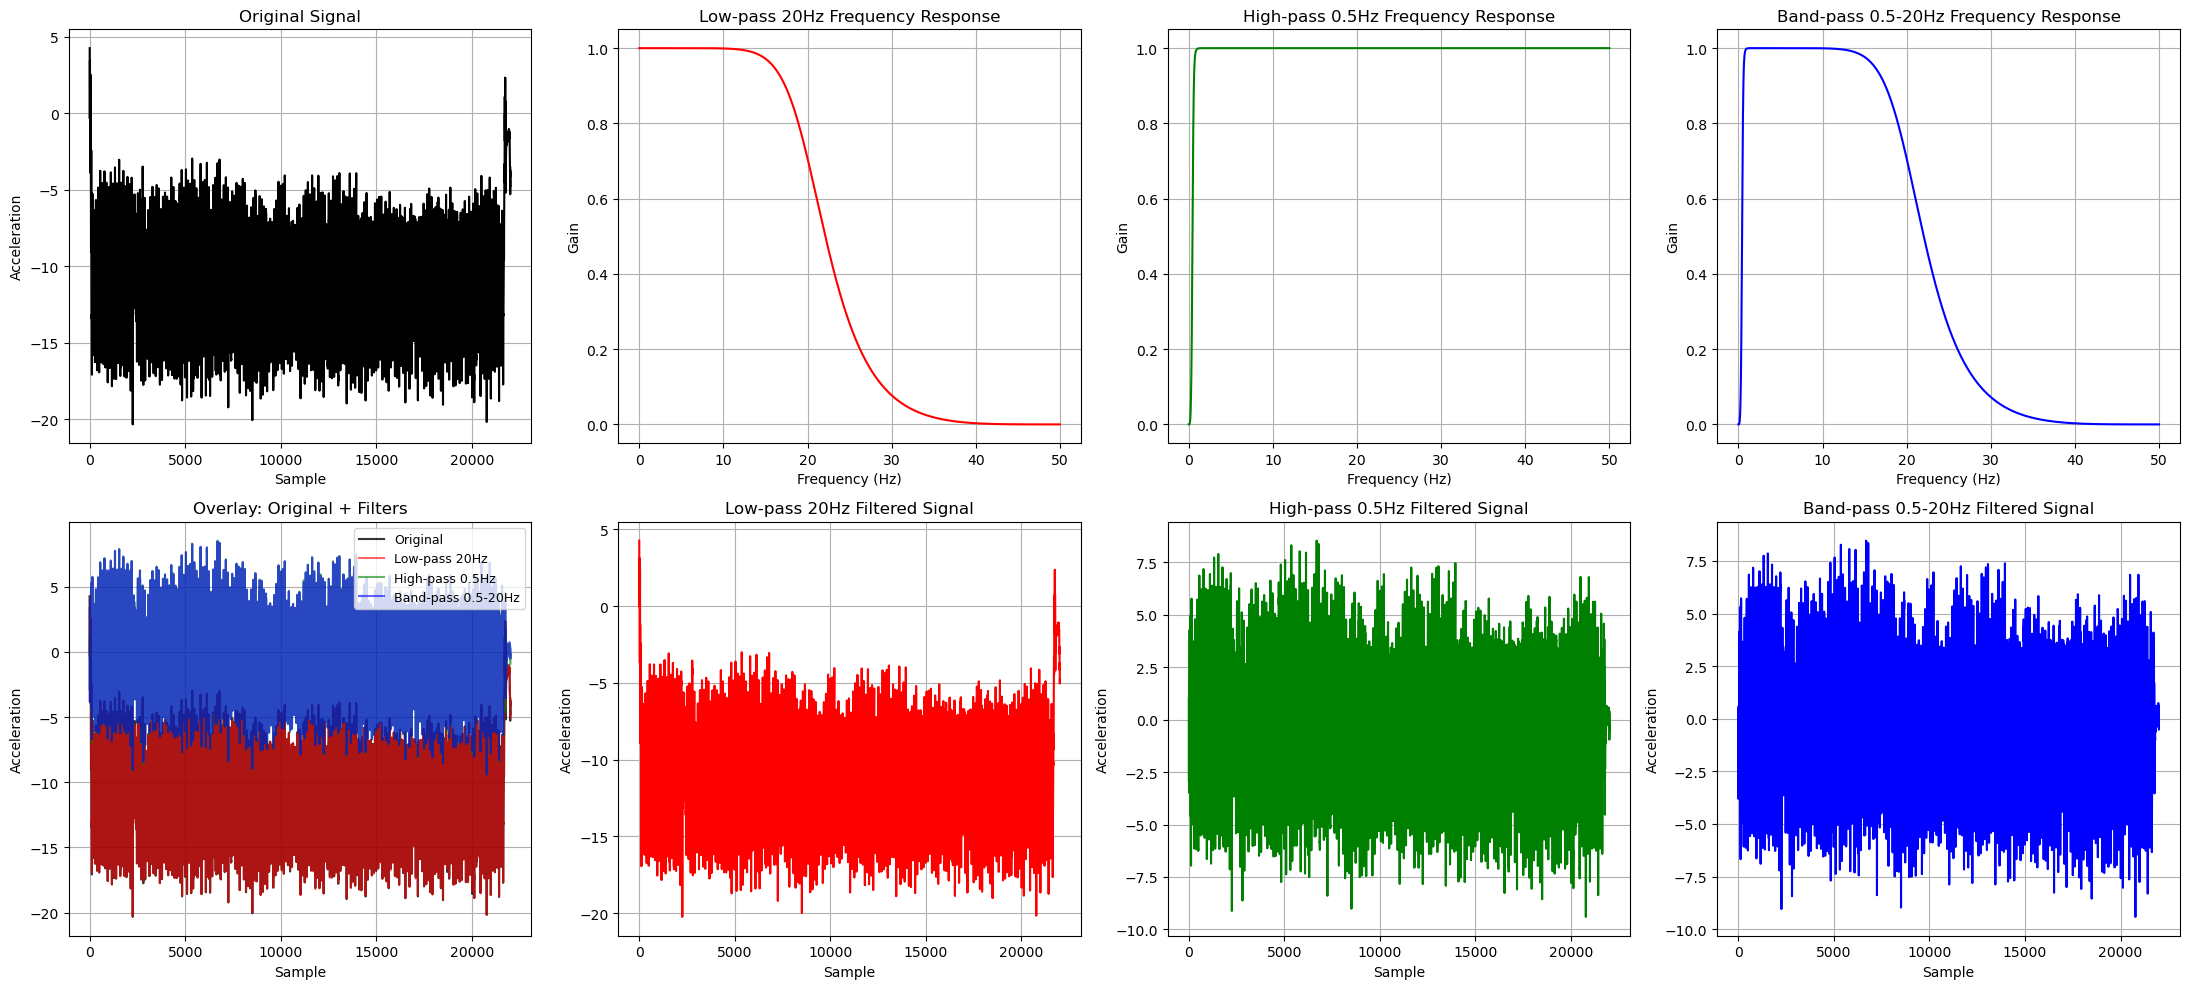

In [2]:
# Parameters

DATA_DIR = "Motion Tracking"
files = {
    "left_hand.csv": 0,
    "right_hand.csv": 1,
    "left_pocket.csv": 2,
    "right_pocket.csv": 3
}

FS = 100                  # Sampling rate (Hz)
WINDOW_SIZE = int(2.5*FS) # 2.5s windows
OVERLAP = 0.5
STEP_SIZE = int(WINDOW_SIZE*(1-OVERLAP))

time_names = ["mean","std","var","max","min","range","rms"]
freq_names = ["dom","energy","entropy"]
axes = ["x","y","z","abs"]

# Filter Design 

def design_filter(filter_type="lowpass", cutoff=20, fs=100, order=4, high_cut=None):
    nyq = 0.5 * fs
    if filter_type == "lowpass":
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low')
    elif filter_type == "highpass":
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='high')
    elif filter_type == "bandpass":
        if high_cut is None:
            raise ValueError("High cutoff must be provided for bandpass")
        normal_cut = [cutoff/nyq, high_cut/nyq]
        b, a = butter(order, normal_cut, btype='band')
    else:
        raise ValueError("filter_type must be 'lowpass', 'highpass', or 'bandpass'")
    return b, a

def apply_filter(signal, b, a):
    return filtfilt(b, a, signal)

# Filter Comparision 

sample_file = os.path.join(DATA_DIR, "left_hand.csv")
df_sample = pd.read_csv(sample_file)
df_sample.columns = ["time","acc_x","acc_y","acc_z","acc_abs"]
signal = df_sample["acc_x"].values

# Design filters
filters = {
    "Low-pass 20Hz": design_filter("lowpass", cutoff=20, fs=FS, order=4),
    "High-pass 0.5Hz": design_filter("highpass", cutoff=0.5, fs=FS, order=4),
    "Band-pass 0.5-20Hz": design_filter("bandpass", cutoff=0.5, high_cut=20, fs=FS, order=4)
}
filtered_signals = {name: apply_filter(signal, b, a) for name, (b, a) in filters.items()}
fig, axes = plt.subplots(2, 4, figsize=(22, 10))

# --- Row 1: Original signal + frequency responses ---
# Column 0: Original signal placeholder
axes[0, 0].plot(signal, color="black")
axes[0, 0].set_title("Original Signal")
axes[0, 0].set_xlabel("Sample")
axes[0, 0].set_ylabel("Acceleration")
axes[0, 0].grid(True)

# Columns 1-3: Frequency responses
colors = ["red", "green", "blue"]
for idx, (name, (b, a)) in enumerate(filters.items(), start=1):
    w, h = freqz(b, a, worN=8000)
    axes[0, idx].plot(0.5*FS*w/np.pi, np.abs(h), color=colors[idx-1])
    axes[0, idx].set_title(f"{name} Frequency Response")
    axes[0, idx].set_xlabel("Frequency (Hz)")
    axes[0, idx].set_ylabel("Gain")
    axes[0, idx].grid(True)

# --- Row 2: Time-domain signals ---
# Column 0: Overlay of all filtered signals + original
axes[1, 0].plot(signal, color="black", label="Original", alpha=0.8)
for (name, filt_signal), color in zip(filtered_signals.items(), colors):
    axes[1, 0].plot(filt_signal, color=color, alpha=0.6, label=name)
axes[1, 0].set_title("Overlay: Original + Filters")
axes[1, 0].set_xlabel("Sample")
axes[1, 0].set_ylabel("Acceleration")
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True)

# Columns 1-3: Individual filtered signals
for idx, (name, filt_signal) in enumerate(filtered_signals.items(), start=1):
    axes[1, idx].plot(filt_signal, color=colors[idx-1])
    axes[1, idx].set_title(f"{name} Filtered Signal")
    axes[1, idx].set_xlabel("Sample")
    axes[1, idx].set_ylabel("Acceleration")
    axes[1, idx].grid(True)

plt.tight_layout()
plt.show()

#### Preprocessing Function (Filtering + Scaling)

In [3]:
def preprocess_file(filepath, label, filter_type="lowpass", cutoff=20, high_cut=None, order=4, discard_seconds=3):
    df = pd.read_csv(filepath)
    df.columns = ["time","acc_x","acc_y","acc_z","acc_abs"]
    
    # Discard first and last few seconds to remove transient effects
    discard_samples = discard_seconds * FS
    df = df.iloc[discard_samples:-discard_samples].reset_index(drop=True)
    
    # Apply chosen filter
    for axis in ["acc_x","acc_y","acc_z","acc_abs"]:
        b, a = design_filter(filter_type, cutoff=cutoff, high_cut=high_cut, fs=FS, order=order)
        df[axis] = apply_filter(df[axis].values, b, a)
    
    # Standardize
    scaler = StandardScaler()
    df[["acc_x","acc_y","acc_z","acc_abs"]] = scaler.fit_transform(df[["acc_x","acc_y","acc_z","acc_abs"]])
    
    df["label"] = label
    return df

### Windowing & Feature Extraction

In [4]:
# ==============================
# 4. Windowing / Segmentation
# ==============================
def sliding_windows(signal):
    return [signal[i:i+WINDOW_SIZE] for i in range(0,len(signal)-WINDOW_SIZE, STEP_SIZE)]

# ==============================
# 5. Feature Extraction
# ==============================
def time_features(x):
    return [np.mean(x), np.std(x), np.var(x), np.max(x), np.min(x), np.ptp(x), np.sqrt(np.mean(x**2))]

def freq_features(x):
    N = len(x)
    X = np.abs(fft(x))[:N//2]
    freqs = np.fft.fftfreq(N, 1/FS)[:N//2]
    dom = freqs[np.argmax(X)]
    energy = np.sum(X**2)
    ent = entropy(X+1e-12)
    return [dom, energy, ent]

def extract_features(df, label):
    axis_names = ["x","y","z","abs"]
    windows = {axis: sliding_windows(df[f"acc_{axis}"].values) for axis in axis_names}
    num_windows = len(windows["x"])
    
    all_rows = []
    for i in range(num_windows):
        row = []
        col_names = []
        for axis in axis_names:
            w = windows[axis][i]
            t_feats = time_features(w)
            f_feats = freq_features(w)
            row.extend(t_feats + f_feats)
            col_names.extend([f"{axis}_time_{name}" for name in time_names])
            col_names.extend([f"{axis}_freq_{name}" for name in freq_names])
        row.append(label)
        if i==0:
            all_col_names = col_names + ["label"]
        all_rows.append(row)
    
    return pd.DataFrame(all_rows, columns=all_col_names)

#### Prepare Data

In [5]:
all_features = []
for file,label in files.items():
    path = os.path.join(DATA_DIR, file)
    df_proc = preprocess_file(path, label)
    all_features.append(extract_features(df_proc, label))

feature_df = pd.concat(all_features, ignore_index=True)
feature_df.to_csv("motion_features.csv", index=False)
print(f"Feature dataset saved: motion_features.csv")

all_col_names = list(feature_df.columns[:-1])
X = feature_df.iloc[:, :-1].values
y = feature_df["label"].values
classes = np.unique(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\n=== Dataset Summary ===")
print(f"Total windows: {len(y)}")
print("Instances per class:")
print(pd.Series(y).value_counts().sort_index())

Feature dataset saved: motion_features.csv

=== Dataset Summary ===
Total windows: 630
Instances per class:
0    170
1    155
2    153
3    152
Name: count, dtype: int64


### Filter comparison 

In [6]:
filter_configs = {
    "lowpass": {"filter_type":"lowpass", "cutoff":20},
    "highpass": {"filter_type":"highpass", "cutoff":0.5},
    "bandpass": {"filter_type":"bandpass", "cutoff":0.5, "high_cut":20}
}
cv = StratifiedKFold(10, shuffle=True, random_state=42)
filter_results = {}

for fname, fparams in filter_configs.items():
    all_features = []
    for file, label in files.items():
        path = os.path.join(DATA_DIR, file)
        df_proc = preprocess_file(path, label, **fparams)
        all_features.append(extract_features(df_proc, label))
    
    feature_df = pd.concat(all_features, ignore_index=True)
    X = feature_df.iloc[:, :-1].values
    y = feature_df["label"].values
    X_scaled_filt = StandardScaler().fit_transform(X)
    
    knn = KNeighborsClassifier(n_neighbors=5)
    scores = cross_val_score(knn, X_scaled_filt, y, cv=cv)
    
    filter_results[fname] = scores.mean()
    print(f"{fname} filter kNN accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

# Decide best filter
best_filter_name = max(filter_results, key=filter_results.get)
print(f"Best filter for kNN: {best_filter_name}")

lowpass filter kNN accuracy: 0.990 ± 0.011
highpass filter kNN accuracy: 0.944 ± 0.022
bandpass filter kNN accuracy: 0.954 ± 0.015
Best filter for kNN: lowpass


### Models

#### kNN

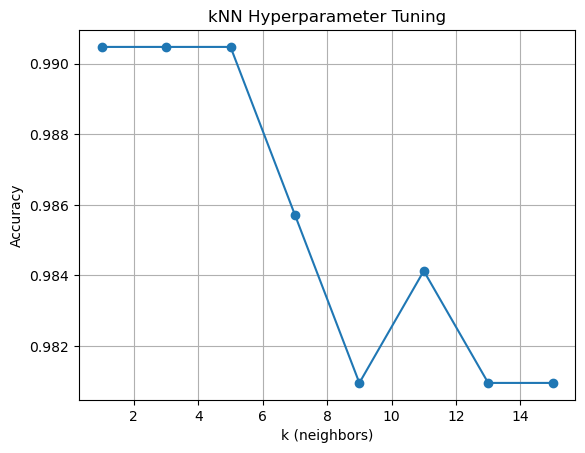

Best k: 1
Best kNN accuracy: 0.990


In [7]:
knn_neighbors = [1, 3, 5, 7, 9, 11,13,15]
knn_scores = []

for k in knn_neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn_scores.append(cross_val_score(knn, X_scaled, y, cv=cv).mean())

best_k = knn_neighbors[np.argmax(knn_scores)]
best_score = knn_scores[np.argmax(knn_scores)]

plt.figure()
plt.plot(knn_neighbors, knn_scores, "o-")
plt.xlabel("k (neighbors)")
plt.ylabel("Accuracy")
plt.title("kNN Hyperparameter Tuning")
plt.grid(True)
plt.show()

print(f"Best k: {best_k}")
print(f"Best kNN accuracy: {best_score:.3f}")


#### Decision Trees

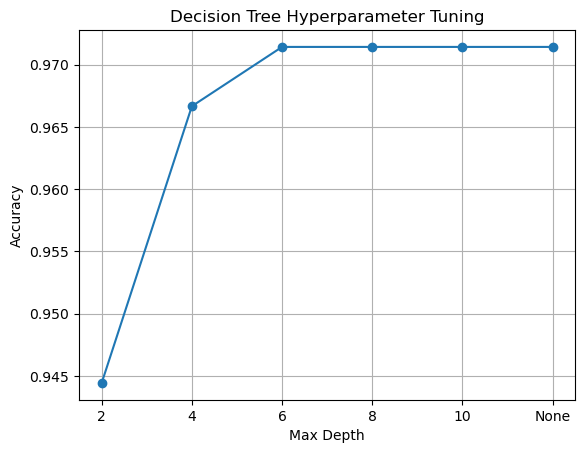

Best Max Depth: 6
Best Decision Tree accuracy: 0.971


In [8]:
dt_depths = [2, 4, 6, 8, 10, None]
dt_scores = []

for d in dt_depths:
    dt = DecisionTreeClassifier(max_depth=d, random_state=42)
    dt_scores.append(cross_val_score(dt, X_scaled, y, cv=cv).mean())

best_dt_idx = np.argmax(dt_scores)
best_dt = dt_depths[best_dt_idx]
best_score = dt_scores[best_dt_idx]

plt.figure()
plt.plot([str(d) for d in dt_depths], dt_scores, "o-")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree Hyperparameter Tuning")
plt.grid(True)
plt.show()

print(f"Best Max Depth: {best_dt}")
print(f"Best Decision Tree accuracy: {best_score:.3f}")


#### Naive Bayes

In [9]:
nb = GaussianNB()

cv_scores = cross_val_score(nb, X_scaled, y, cv=cv)

print(f"Naive Bayes Accuracy: {cv_scores.mean():.3f}")

Naive Bayes Accuracy: 0.971


#### MultiLayer Perception (MLP)

In [10]:
mlp_configs = [
    {"hidden_layer_sizes": (32,), "alpha": 0.0001},
    {"hidden_layer_sizes": (64,), "alpha": 0.0001},
    {"hidden_layer_sizes": (32, 64), "alpha": 0.001},
    {"hidden_layer_sizes": (64, 32), "alpha": 0.001},
    {"hidden_layer_sizes": (32, 64, 128), "alpha": 0.001},
    {"hidden_layer_sizes": (128, 64, 32), "alpha": 0.001},
]

mlp_scores = []
for cfg in mlp_configs:
    mlp = MLPClassifier(
        hidden_layer_sizes=cfg["hidden_layer_sizes"],
        alpha=cfg["alpha"],
        max_iter=500,
        random_state=42
    )
    mlp_scores.append({
        "config": cfg,
        "accuracy": cross_val_score(mlp, X_scaled, y, cv=cv).mean()
    })

mlp_best = max(mlp_scores, key=lambda x: x["accuracy"])
print("Best MLP configuration:", mlp_best["config"])
print("Best MLP accuracy: {:.3f}".format(mlp_best["accuracy"]))


Best MLP configuration: {'hidden_layer_sizes': (32,), 'alpha': 0.0001}
Best MLP accuracy: 0.995


## Classifiers Comparision

In [11]:
print("\nBest hyperparameters:")
print(f"  kNN k = {best_k}")
print(f"  Decision Tree depth = {best_dt}")
print(f"  MLP config = {mlp_best['config']}")

best_models = {
    "kNN": KNeighborsClassifier(n_neighbors=best_k),
    "DecisionTree": DecisionTreeClassifier(max_depth=best_dt, random_state=42),
    "MLP": MLPClassifier(
        hidden_layer_sizes=mlp_best["config"]["hidden_layer_sizes"],
        alpha=mlp_best["config"]["alpha"],
        max_iter=500,
        random_state=42
    ),
    "NaiveBayes": GaussianNB()
}


Best hyperparameters:
  kNN k = 1
  Decision Tree depth = 6
  MLP config = {'hidden_layer_sizes': (32,), 'alpha': 0.0001}


### Metrics summary table

In [12]:
import time
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

metrics_summary = []

for name, model in best_models.items():
    start_time = time.time()
    
    # Cross-validated predictions
    y_pred = cross_val_predict(model, X_scaled, y, cv=cv)
    
    # Cross-validated probabilities for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_prob = cross_val_predict(model, X_scaled, y, cv=cv, method="predict_proba")
    else:  # fallback
        y_prob = cross_val_predict(model, X_scaled, y, cv=cv, method="predict_proba")
    
    elapsed_time = time.time() - start_time  # in seconds
    
    # Binarize for multi-class ROC-AUC
    y_bin = label_binarize(y, classes=classes)
    
    metrics_summary.append({
        "Model": name,
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred, average="macro"),
        "Recall": recall_score(y, y_pred, average="macro"),
        "F1": f1_score(y, y_pred, average="macro"),
        "ROC-AUC": roc_auc_score(y_bin, y_prob, average="macro", multi_class="ovr"),
        "Time (s)": elapsed_time
    })

metrics_df = pd.DataFrame(metrics_summary)
print("\n=== Model Performance Summary ===")
print(metrics_df.round(3))


=== Model Performance Summary ===
          Model  Accuracy  Precision  Recall     F1  ROC-AUC  Time (s)
0           kNN     0.990      0.991   0.990  0.990    0.994     1.757
1  DecisionTree     0.971      0.971   0.971  0.971    0.981     0.255
2           MLP     0.995      0.995   0.995  0.995    0.998    11.696
3    NaiveBayes     0.971      0.973   0.972  0.972    0.995     0.078


### Reductionality methods + Confusion matrices

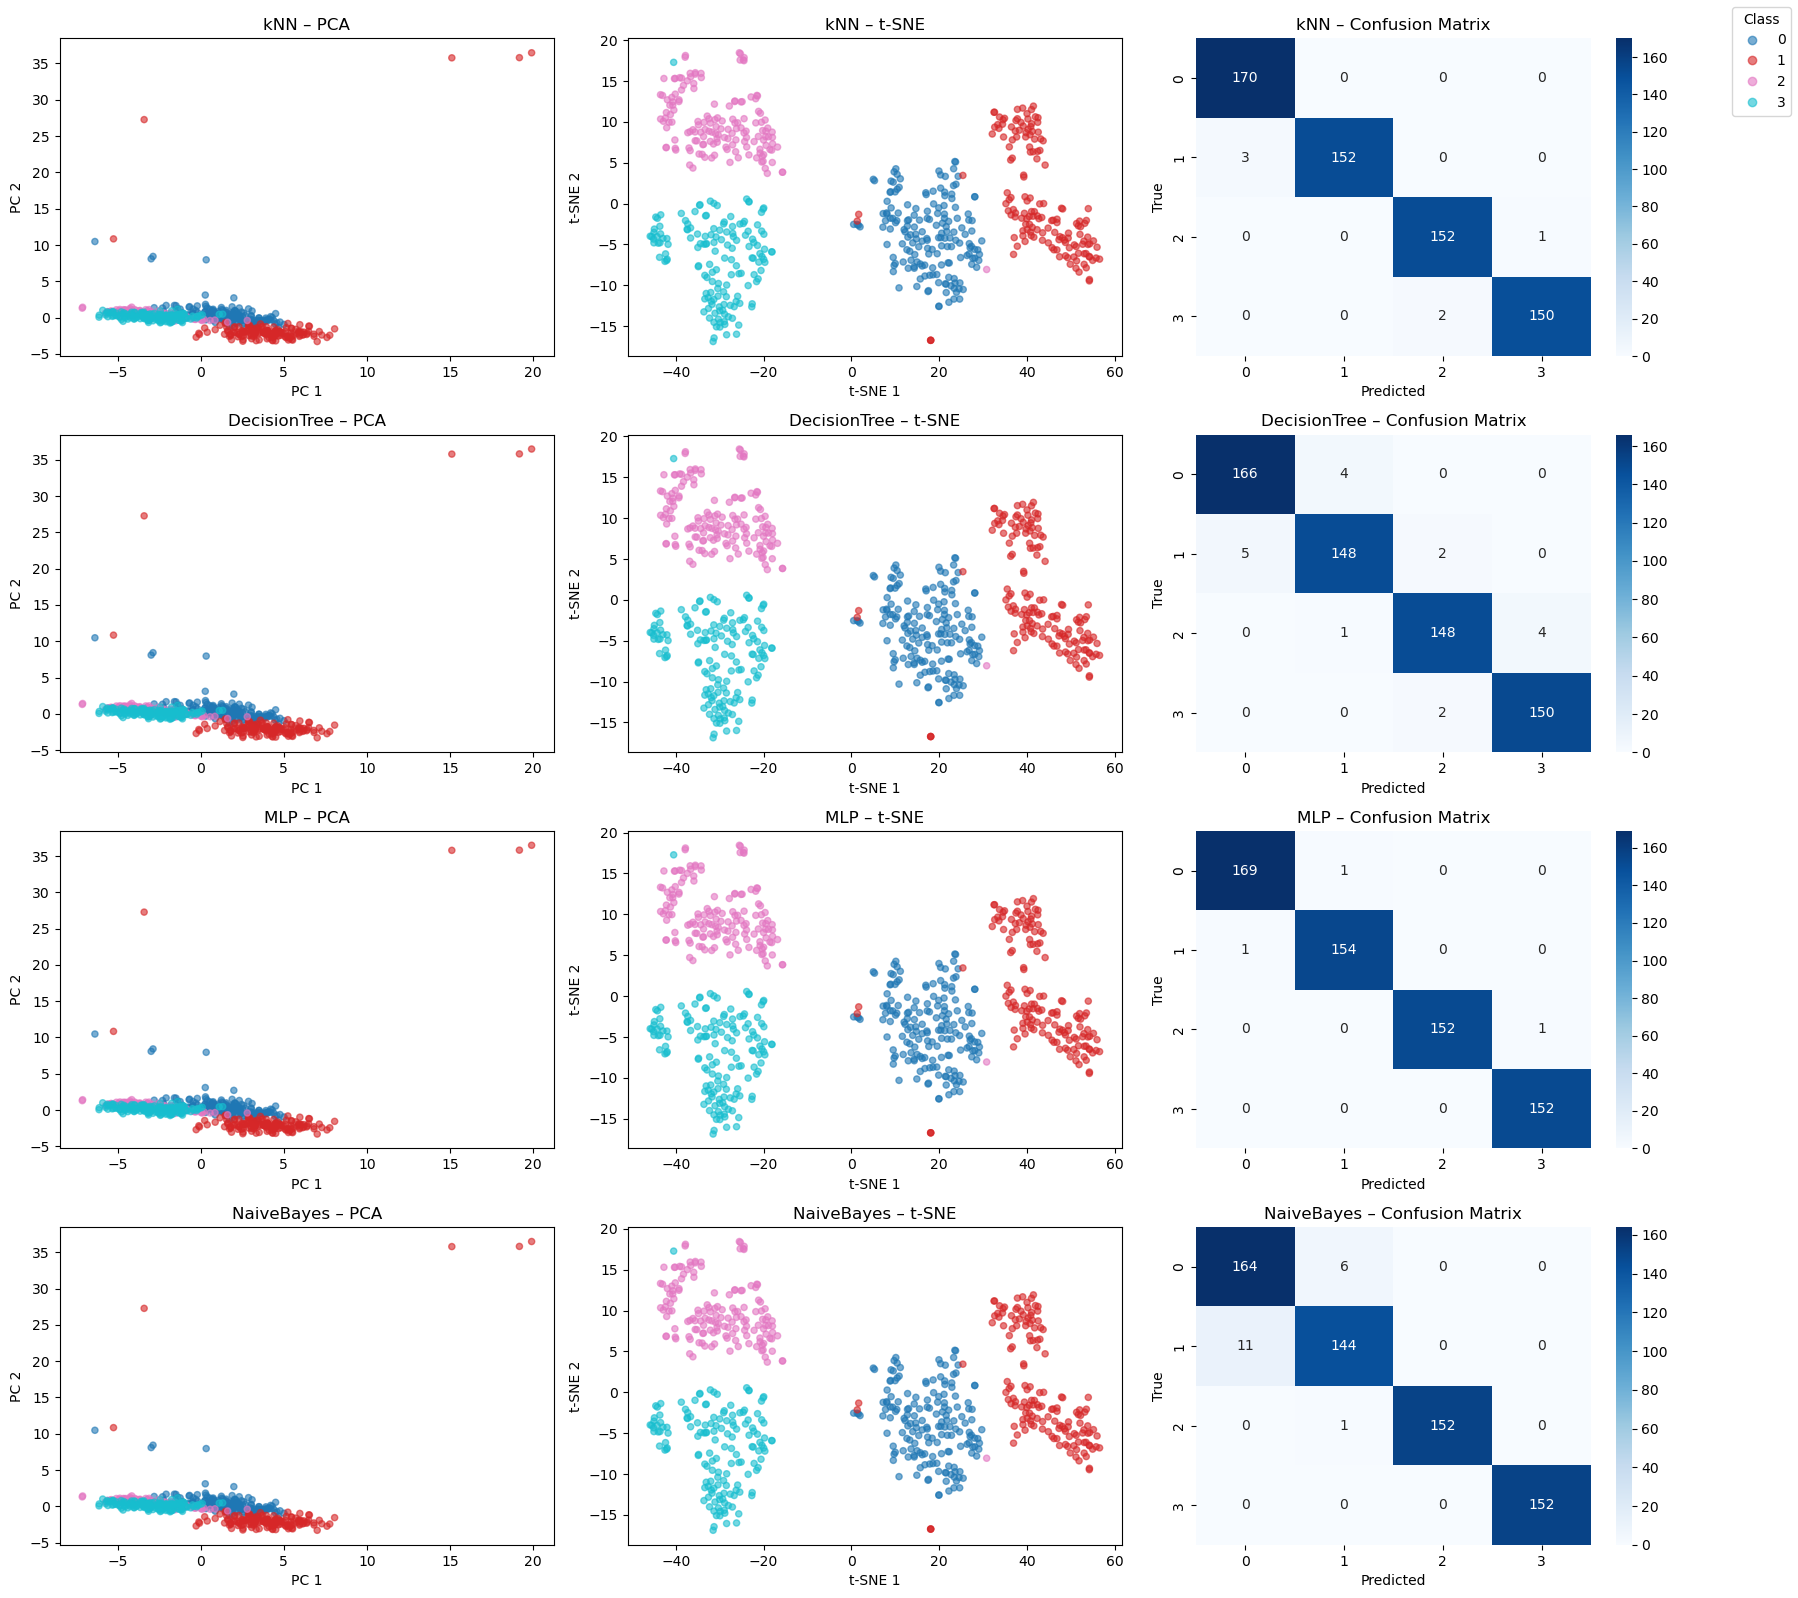

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    random_state=42
)
X_tsne = tsne.fit_transform(X_scaled)

fig, axes = plt.subplots(
    nrows=len(best_models),
    ncols=3,
    figsize=(18, 4 * len(best_models))
)

for row_idx, (name, model) in enumerate(best_models.items()):
    
    # Cross-validated predictions
    y_pred = cross_val_predict(model, X_scaled, y, cv=cv)

    # ------------------------------
    # (1) PCA scatter
    # ------------------------------
    ax_pca = axes[row_idx, 0]
    scatter_pca = ax_pca.scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        c=y,
        cmap="tab10",
        alpha=0.6,
        s=20
    )
    ax_pca.set_title(f"{name} – PCA")
    ax_pca.set_xlabel("PC 1")
    ax_pca.set_ylabel("PC 2")

    # ------------------------------
    # (2) t-SNE scatter
    # ------------------------------
    ax_tsne = axes[row_idx, 1]
    scatter_tsne = ax_tsne.scatter(
        X_tsne[:, 0],
        X_tsne[:, 1],
        c=y,
        cmap="tab10",
        alpha=0.6,
        s=20
    )
    ax_tsne.set_title(f"{name} – t-SNE")
    ax_tsne.set_xlabel("t-SNE 1")
    ax_tsne.set_ylabel("t-SNE 2")

    # ------------------------------
    # (3) Confusion Matrix
    # ------------------------------
    cm = confusion_matrix(y, y_pred)
    ax_cm = axes[row_idx, 2]
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes,
        ax=ax_cm
    )
    ax_cm.set_xlabel("Predicted")
    ax_cm.set_ylabel("True")
    ax_cm.set_title(f"{name} – Confusion Matrix")

# Shared legend (only once)
handles, _ = scatter_pca.legend_elements()
fig.legend(
    handles,
    classes,
    title="Class",
    loc="upper right",
    fontsize=10
)

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()


### Feature-Group Importance Matrix

In [ ]:
feature_groups = {
    "x_time": [i for i, f in enumerate(all_col_names) if f.startswith("x_time")],
    "y_time": [i for i, f in enumerate(all_col_names) if f.startswith("y_time")],
    "z_time": [i for i, f in enumerate(all_col_names) if f.startswith("z_time")],
    "abs_time": [i for i, f in enumerate(all_col_names) if f.startswith("abs_time")],
    "x_freq": [i for i, f in enumerate(all_col_names) if f.startswith("x_freq")],
    "y_freq": [i for i, f in enumerate(all_col_names) if f.startswith("y_freq")],
    "z_freq": [i for i, f in enumerate(all_col_names) if f.startswith("z_freq")],
    "abs_freq": [i for i, f in enumerate(all_col_names) if f.startswith("abs_freq")]
}

importance_rows = []

for name, model in best_models.items():
    model.fit(X_scaled, y)

    if name == "DecisionTree":
        importances = model.feature_importances_
    else:
        result = permutation_importance(
            model, X_scaled, y,
            n_repeats=10, random_state=42, scoring="accuracy"
        )
        importances = result.importances_mean

    row = {"Model": name}
    for group, idxs in feature_groups.items():
        row[group] = np.mean(importances[idxs])
    importance_rows.append(row)

importance_df = pd.DataFrame(importance_rows).set_index("Model")

plt.figure(figsize=(11, 4))
sns.heatmap(
    importance_df,
    cmap="viridis",
    annot=True,
    fmt=".3f"
)
plt.title("Feature Importance by Model and Feature Group")
plt.ylabel("Model")
plt.xlabel("Feature Group")
plt.tight_layout()
plt.show()